In [64]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import DataLoader

plt.ion()  

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
transform = transforms.Compose( [                                  
                                 transforms.Resize((224,224)),
                                 transforms.RandomRotation(10),
                                 transforms.RandomHorizontalFlip(), 
                                 transforms.ToTensor(),
                                  ])

def train_val_dataset(dataset, val_split=0.3):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

dataset = ImageFolder('/content/drive/MyDrive/brain', transform=transform)
print('length of dataset :',len(dataset))
datasets = train_val_dataset(dataset)
print('length of trainset :',len(datasets['train']))
print('length of validation set :',len(datasets['val']))
print(dataset)

length of dataset : 3000
length of trainset : 2100
length of validation set : 900
Dataset ImageFolder
    Number of datapoints: 3000
    Root location: /content/drive/MyDrive/brain
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               RandomRotation(degrees=[-10.0, 10.0], resample=False, expand=False)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [67]:
dataloaders = {x:DataLoader(datasets[x], 16, shuffle=True, num_workers=4) for x in ['train','val']}

In [68]:
inputs, classes = next(iter(dataloaders['train']))
print(inputs.shape, classes.shape)

torch.Size([16, 3, 224, 224]) torch.Size([16])


In [69]:
class_names = dataset.classes
print(class_names)

['no', 'yes']


In [70]:
dataset_sizes={'val':900,'train':2100}

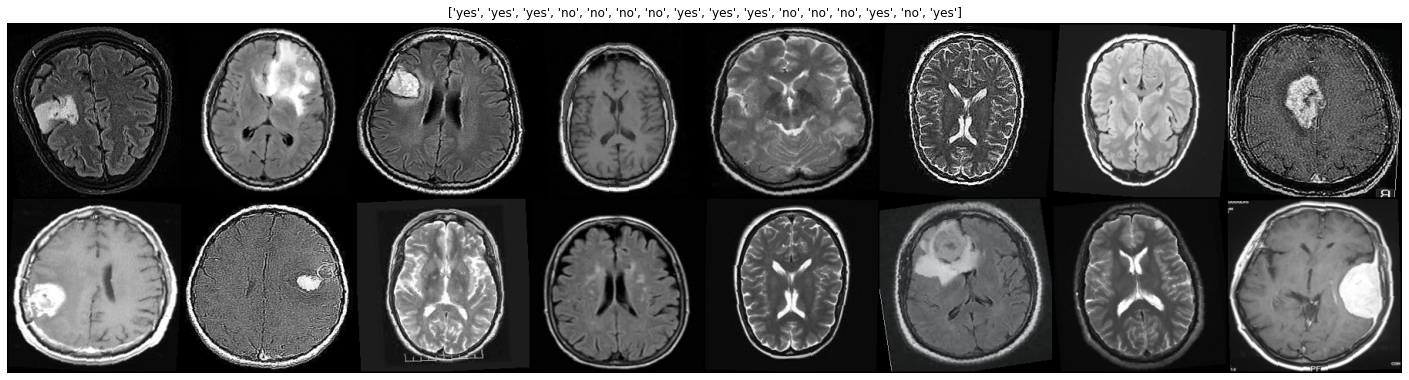

In [71]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(25, 25))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

show_databatch(inputs, classes)

In [72]:
def visualize_model(vgg, num_images=6):
    was_training = vgg.training
    
    vgg.train(False)
    vgg.eval() 
    
    images_so_far = 0

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        size = inputs.size()[0]
        
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        
        outputs = vgg(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    vgg.train(mode=was_training)

In [82]:
def eval_model(vgg, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders['val'])
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(dataloaders['val']):
        if i % 10 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        vgg.train(False)
        vgg.eval()
        inputs, labels = data

        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = vgg(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        loss_test += loss.item()
        acc_test += torch.sum(preds == labels.data).item()

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / dataset_sizes['val']
    avg_acc = acc_test / dataset_sizes['val']
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)


In [83]:
vgg19 = models.vgg19(pretrained=True)
print(vgg19.classifier[6].out_features)  


for param in vgg19.features.parameters():
    param.require_grad = False


num_features = vgg19.classifier[6].in_features
features = list(vgg19.classifier.children())[:-1] 
features.extend([nn.Linear(num_features, len(class_names))])
vgg19.classifier = nn.Sequential(*features)
print(vgg19)

1000
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1),

In [84]:
if use_gpu:
    vgg19.cuda()
    
criterion = nn.CrossEntropyLoss()
#optimizer_ft = optim.SGD(vgg19.parameters(), lr=0.001, weight_decay=1e-5, momentum=0.9)
optimizer_ft = optim.Adam(vgg19.parameters(), lr=1e-4, weight_decay=1e-5)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [85]:
print("Test before training")
eval_model(vgg19, criterion)

Test before training
Evaluating model
----------
Test batch 50/57
Evaluation completed in 0m 7s
Avg loss (test): 0.0428
Avg acc (test): 0.5633
----------


In [86]:
def train_model(vgg, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloaders['train'])
    val_batches = len(dataloaders['val'])
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        vgg.train(True)
        
        for i, data in enumerate(dataloaders['train']):
            if i % 100 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches), end='', flush=True)
                
            if i >= train_batches:
                break
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            acc_train += torch.sum(preds == labels.data).item()
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()

        avg_loss = loss_train / dataset_sizes['train']
        avg_acc = acc_train / dataset_sizes['train']
        
        vgg.train(False)
        vgg.eval()
            
        for i, data in enumerate(dataloaders['val']):
            if i % 100 == 0:
                print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            loss_val += loss.item()
            acc_val += torch.sum(preds == labels.data).item()

            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        avg_loss_val = loss_val / dataset_sizes['val']
        avg_acc_val = acc_val / dataset_sizes['val']
        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    vgg.load_state_dict(best_model_wts)
    return vgg

In [87]:
vgg19 = train_model(vgg19, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/10
----------
Training batch 0/132

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/u

Training batch 100/132


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.

Validation batch 0/57
Epoch 0 result: 
Avg loss (train): 0.0237
Avg acc (train): 0.8157
Avg loss (val): 0.0101
Avg acc (val): 0.9411
----------

Epoch 1/10
----------


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Traceback (most recent call last):
Traceback (most recent call

Training batch 100/132


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Validation batch 0/57
Epoch 1 result: 
Avg loss (train): 0.0089
Avg acc (train): 0.9548
Avg loss (val): 0.0048
Avg acc (val): 0.9733
----------

Epoch 2/10
----------


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Training batch 0/132

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/u

Training batch 100/132


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/

Validation batch 0/57
Epoch 2 result: 
Avg loss (train): 0.0043
Avg acc (train): 0.9819
Avg loss (val): 0.0025
Avg acc (val): 0.9878
----------

Epoch 3/10
----------


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLo

Training batch 100/132


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._M

Validation batch 0/57
Epoch 3 result: 
Avg loss (train): 0.0044
Avg acc (train): 0.9781
Avg loss (val): 0.0017
Avg acc (val): 0.9944
----------

Epoch 4/10
----------
Training batch 0/132

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/u

Training batch 100/132


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
  File "/usr/lib/python3.6/multiprocessing/process.py", line 1

Validation batch 0/57
Epoch 4 result: 
Avg loss (train): 0.0043
Avg acc (train): 0.9781
Avg loss (val): 0.0024
Avg acc (val): 0.9922
----------

Epoch 5/10
----------


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutd

Training batch 100/132


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/u

Validation batch 0/57

    assert self._parent_pid == os.getpid(), 'can only join a child process'
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIte


Epoch 5 result: 
Avg loss (train): 0.0024
Avg acc (train): 0.9876
Avg loss (val): 0.0051
Avg acc (val): 0.9822
----------

Epoch 6/10
----------
Training batch 0/132

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Training batch 100/132


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object

Validation batch 0/57

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process



Epoch 6 result: 
Avg loss (train): 0.0040
Avg acc (train): 0.9857
Avg loss (val): 0.0027
Avg acc (val): 0.9844
----------

Epoch 7/10
----------


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Training batch 0/132

    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Training batch 100/132


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
Traceback (most recent call

Validation batch 0/57
Epoch 7 result: 
Avg loss (train): 0.0011
Avg acc (train): 0.9943
Avg loss (val): 0.0019
Avg acc (val): 0.9933
----------

Epoch 8/10
----------


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)


Training batch 0/132

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    assert self._parent_pid == os.getpid(), 'can only join a child process'
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._Multi

Training batch 100/132


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Validation batch 0/57
Epoch 8 result: 
Avg loss (train): 0.0005
Avg acc (train): 0.9962
Avg loss (val): 0.0021
Avg acc (val): 0.9900
----------

Epoch 9/10
----------


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Training batch 100/132


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object

Validation batch 0/57
Epoch 9 result: 
Avg loss (train): 0.0103
Avg acc (train): 0.9471
Avg loss (val): 0.0104
Avg acc (val): 0.9467
----------


Training completed in 8m 39s
Best acc: 0.9944


In [88]:
eval_model(vgg19, criterion)

Evaluating model
----------


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff6374d29b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Test batch 50/57
Evaluation completed in 0m 7s
Avg loss (test): 0.0019
Avg acc (test): 0.9933
----------


Ground truth:


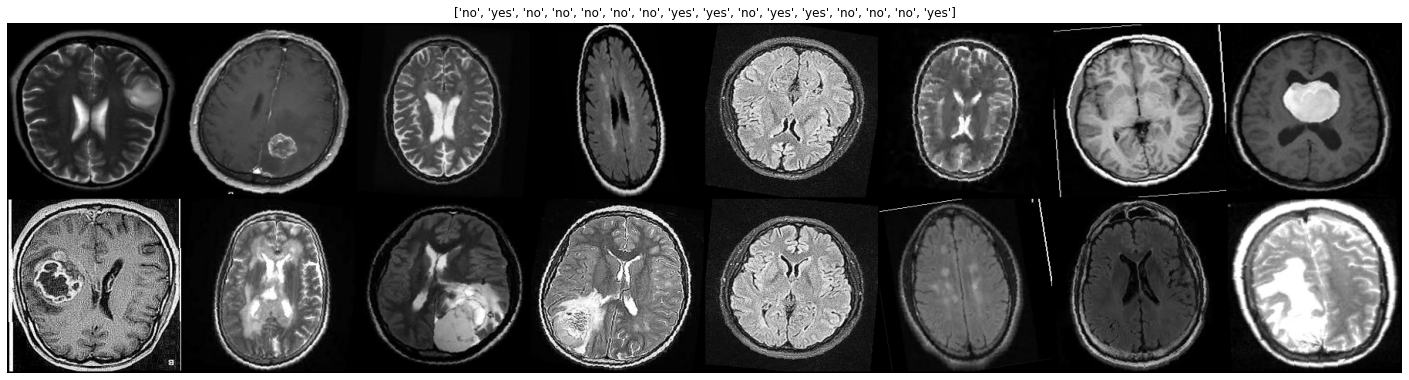

Prediction:


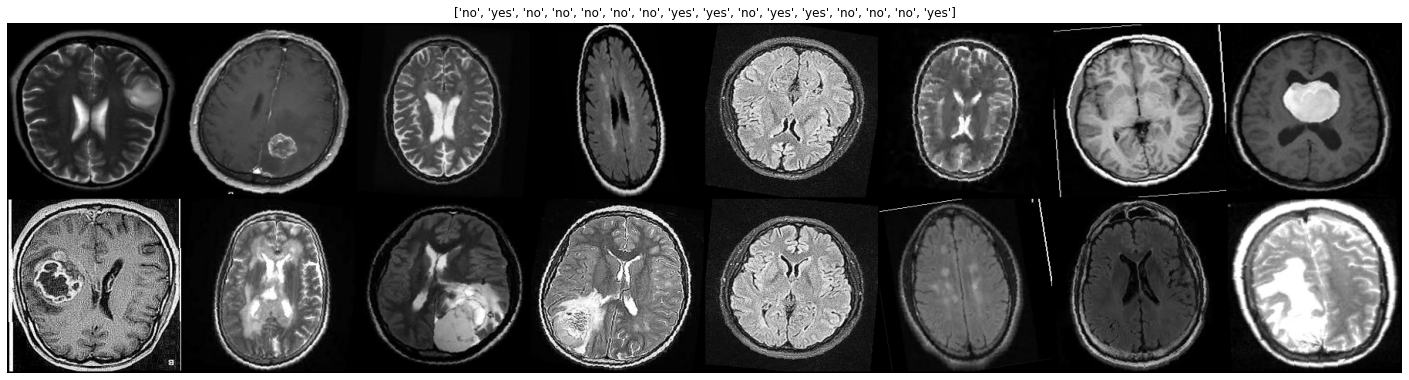

Ground truth:


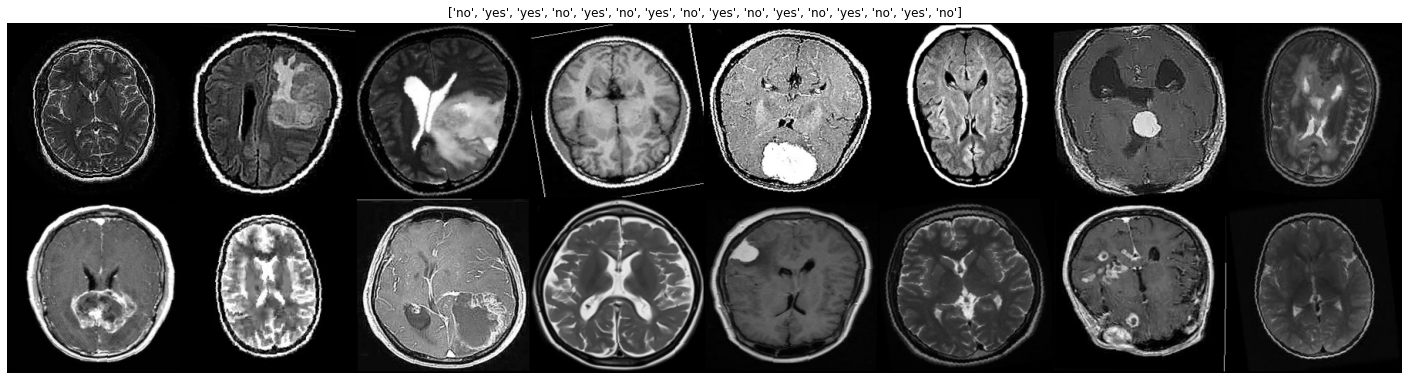

Prediction:


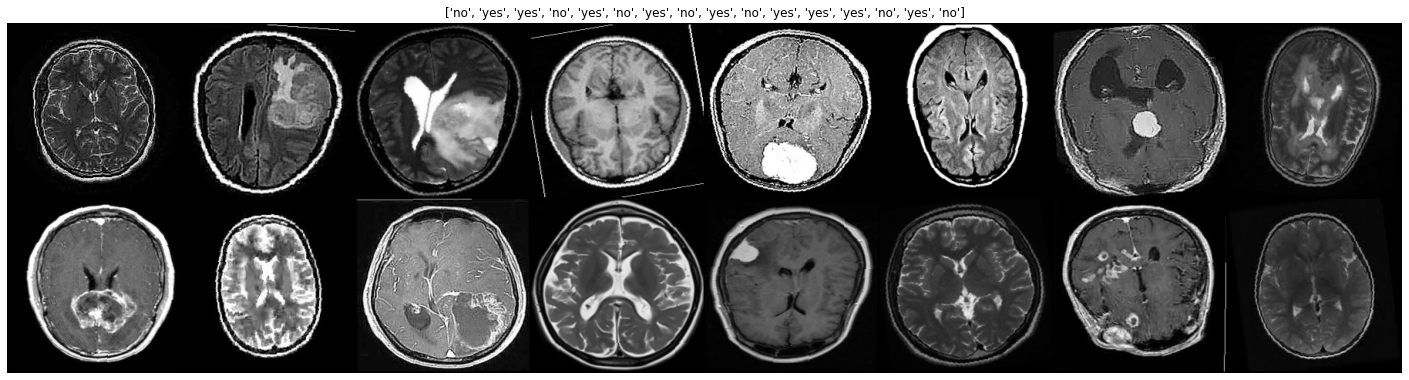

In [89]:
visualize_model(vgg19, num_images=32)